<a href="https://colab.research.google.com/github/priyankachahal/student_research/blob/master/ecg_classification_multi_layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.layers import Dense, LSTM, Dropout, Activation
from keras.models import Sequential
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


In [0]:
def get_input_file():
    dataset = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ecg-classification/dataset/ecg_dataset.csv', header=None, engine='python')
    # drop rows with NaN from the data frame
    dataset = dataset.dropna()
    dataset = dataset.sort_values(dataset.columns[1])
    cols = list(dataset.columns.values)
    cols.pop(cols.index(dataset.columns[0]))
    dataset = dataset[cols + [dataset.columns[0]]]
    dataset.columns = ['col ' + str(i) for i in range(0, len(dataset.columns))]
    dataset.drop(dataset.columns[[0]], axis=1, inplace=True)
    return dataset
input_dataset = get_input_file()
input_data = input_dataset.values

In [4]:
print(input_dataset.shape)
input_dataset.head(5)

(2168, 301)


,col 1,col 2,col 3,col 4,col 5,col 6,col 7,col 8,col 9,col 10,col 11,col 12,col 13,col 14,col 15,col 16,col 17,col 18,col 19,col 20,col 21,col 22,col 23,col 24,col 25,col 26,col 27,col 28,col 29,col 30,col 31,col 32,col 33,col 34,col 35,col 36,col 37,col 38,col 39,col 40,...,col 262,col 263,col 264,col 265,col 266,col 267,col 268,col 269,col 270,col 271,col 272,col 273,col 274,col 275,col 276,col 277,col 278,col 279,col 280,col 281,col 282,col 283,col 284,col 285,col 286,col 287,col 288,col 289,col 290,col 291,col 292,col 293,col 294,col 295,col 296,col 297,col 298,col 299,col 300,col 301
0,0.319985,0.319828,0.320149,0.320924,0.322135,0.323784,0.325899,0.328530,0.331726,0.335513,0.339898,0.344869,0.350388,0.356371,0.362680,0.369123,0.375489,0.381619,0.387428,0.392898,0.398078,0.403042,0.407883,0.412719,0.417701,0.422991,0.428746,0.435125,0.442297,0.450439,0.459715,0.470269,0.482209,0.495585,0.510340,0.526319,0.543287,0.560947,0.578983,0.597097,...,0.323508,0.308173,0.291748,0.274711,0.257573,0.240829,0.224917,0.210186,0.196883,0.185151,0.175017,0.166424,0.159259,0.153358,0.148512,0.144483,0.141020,0.137869,0.134757,0.131418,0.127642,0.123309,0.118385,0.112899,0.106927,0.100574,0.093945,0.087121,0.080141,0.073011,0.065688,0.058100,0.050197,0.041988,0.033535,0.024949,0.016391,0.008037,0.000000,0
930,0.472396,0.474618,0.477974,0.482385,0.487663,0.493559,0.499823,0.506222,0.512576,0.518769,0.524748,0.530503,0.536055,0.541442,0.546707,0.551910,0.557158,0.562599,0.568401,0.574727,0.581693,0.589324,0.597527,0.606097,0.614765,0.623257,0.631367,0.639008,0.646237,0.653264,0.660410,0.668036,0.676453,0.685858,0.696306,0.707709,0.719889,0.732631,0.745764,0.759208,...,0.057693,0.053177,0.048741,0.044551,0.040807,0.037721,0.035478,0.034218,0.034015,0.034865,0.036696,0.039386,0.042754,0.046557,0.050493,0.054211,0.057342,0.059518,0.060382,0.059591,0.056858,0.051998,0.044989,0.036069,0.025827,0.015284,0.005979,0.000012,0.000000,0.008947,0.030012,0.066176,0.119842,0.192408,0.283894,0.392666,0.515348,0.646921,0.781044,38
709,0.205606,0.207352,0.209079,0.210717,0.212195,0.213440,0.214384,0.214959,0.215106,0.214780,0.213958,0.212647,0.210891,0.208775,0.206414,0.203944,0.201508,0.199237,0.197238,0.195576,0.194272,0.193299,0.192592,0.192061,0.191606,0.191120,0.190506,0.189679,0.188577,0.187155,0.185399,0.183321,0.180956,0.178358,0.175591,0.172731,0.169869,0.167088,0.164459,0.162021,...,0.054349,0.053907,0.053290,0.052548,0.051766,0.051045,0.050487,0.050176,0.050165,0.050461,0.051021,0.051755,0.052535,0.053219,0.053676,0.053803,0.053538,0.052856,0.051770,0.050327,0.048604,0.046699,0.044723,0.042786,0.041004,0.039484,0.038312,0.037544,0.037188,0.037211,0.037533,0.038042,0.038608,0.039107,0.039452,0.039607,0.039591,0.039473,0.039368,29
2009,0.313047,0.316614,0.319218,0.320706,0.321015,0.320203,0.318437,0.315973,0.313120,0.310181,0.307413,0.304991,0.302999,0.301412,0.300095,0.298841,0.297414,0.295580,0.293123,0.289880,0.285765,0.280768,0.274958,0.268473,0.261507,0.254295,0.247087,0.240119,0.233596,0.227686,0.222501,0.218108,0.214527,0.211751,0.209759,0.208524,0.208017,0.208209,0.209052,0.210453,...,0.045901,0.047243,0.048082,0.048234,0.047609,0.046228,0.044221,0.041803,0.039245,0.036832,0.034809,0.033357,0.032573,0.032480,0.033046,0.034216,0.035930,0.038145,0.040833,0.043969,0.047508,0.051360,0.055372,0.059318,0.062903,0.065795,0.067686,0.068341,0.067639,0.065599,0.062385,0.058283,0.053649,0.048843,0.044163,0.039800,0.035817,0.032161,0.028688,81
1794,0.429384,0.420704,0.413033,0.406798,0.402287,0.399668,0.399026,0.400383,0.403713,0.408968,0.416074,0.424916,0.435333,0.447147,0.460187,0.474283,0.489229,0.504770,0.520606,0.536377,0.551671,0.566040,0.579056,0.590352,0.599682,0.606992,0.612451,0.616430,0.619462,0.622195,0.625312,0.629428,0.634989,0.642227,0.651159,0.661613,0.673287,0.685833,0.698917,0.712279,...,0.069902,0.066875,0.062125,0.056071,0.049220,0.042079,0.035091,0.028588,0.022768,0.017700,0.013379,0.009782,0.006910,0.004814,0.003610,0.003457,0.004

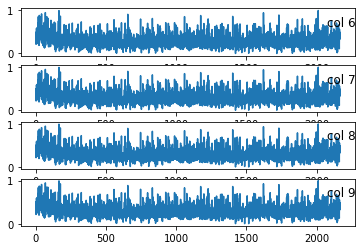

In [5]:
# specify columns to plot
values = input_dataset.values
groups = [5, 6, 7, 8]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(input_dataset.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [0]:
def sample_training_dataset(input_values, percentage = 0.7):
  freqmap = np.array(np.unique(input_values[:, [input_values.shape[1] - 1]].astype(int), return_counts=True)).T
  freqmap[:,1] = freqmap[:,1].astype(float) * percentage
  # stores the required freq of each label
  labelCountDict = {};
  for label, freq in freqmap:
    labelCountDict[label] = freq
  train_arr, test_arr = [], []
  # go through each row of input array after removing NaN
  for row in input_values:
    label_column_index = row[values.shape[1] - 1]
    # if we still have required freq of label, we add to train dataset or add to test dataset
    if labelCountDict[label_column_index] > 0:
      train_arr.append(row)
      labelCountDict[label_column_index] = labelCountDict[label_column_index] - 1
    else:
      test_arr.append(row)
  return np.array(train_arr), np.array(test_arr)

In [8]:
# make sure the percentage is between >= 0.1 and <= 0.9, this samples the dataset but maintains order of labels.
train, test = sample_training_dataset(values, 0.8)
timestep = 1
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], timestep, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], timestep, test_X.shape[1]))
# keep labels as int
train_y = train_y.astype(int)
test_y = test_y.astype(int)

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1699, 1, 300) (1699,) (469, 1, 300) (469,)


In [50]:
model = Sequential()
model.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(90, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['mse'])
print(model.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 200)               400800    
_________________________________________________________________
dense_15 (Dense)             (None, 90)                18090     
Total params: 418,890
Trainable params: 418,890
Non-trainable params: 0
_________________________________________________________________
None


In [51]:
history = model.fit(train_X, train_y, epochs=140, batch_size=100, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 1699 samples, validate on 469 samples
Epoch 1/140
 - 2s - loss: 4.3750 - mean_squared_error: 2642.4143 - val_loss: 4.2048 - val_mean_squared_error: 2634.1015
Epoch 2/140
 - 0s - loss: 3.9900 - mean_squared_error: 2642.4143 - val_loss: 3.7300 - val_mean_squared_error: 2634.1016
Epoch 3/140
 - 0s - loss: 3.5185 - mean_squared_error: 2642.4145 - val_loss: 3.2629 - val_mean_squared_error: 2634.1017
Epoch 4/140
 - 0s - loss: 3.1157 - mean_squared_error: 2642.4146 - val_loss: 2.8962 - val_mean_squared_error: 2634.1018
Epoch 5/140
 - 0s - loss: 2.7944 - mean_squared_error: 2642.4146 - val_loss: 2.6199 - val_mean_squared_error: 2634.1020
Epoch 6/140
 - 0s - loss: 2.5445 - mean_squared_error: 2642.4147 - val_loss: 2.4024 - val_mean_squared_error: 2634.1021
Epoch 7/140
 - 0s - loss: 2.3425 - mean_squared_error: 2642.4149 - val_loss: 2.2256 - val_mean_squared_error: 2634.1023
Epoch 8/140
 - 0s - loss: 2.1696 - mean_squared_error: 2642.4151 - val_loss: 2.0753 - val_mean_squared_error: 263

In [0]:
results = model.predict(test_X)

In [0]:
final_results = np.arange(test_y.shape[0])
index = 0
for c in results:
  ind = np.argmax(c)
  final_results[index] = ind 
  index = index + 1;

In [54]:
print("Actual classes:", test_y[:30])
print("Predicted classes:", final_results[:30])

Actual classes: [87 76 76 73  4 73  4 12  4 50 73 35 12 22  4 22 35 12 61 37 50 66 38 63
 31 88 73 13  8 54]
Predicted classes: [21 76 76 73  4 73  4 12  4 50 73 35 12 22  4 22 35 12 61 37 50 66 38 63
 31 88 73 13  8 54]


In [55]:
correct_classification = 0
total_classification = 0
for d, c in zip(final_results, test_y):
  total_classification = total_classification + 1
  if int(d) == int(c):
    correct_classification = correct_classification + 1
print(total_classification, correct_classification)

469 425


In [56]:
score = (correct_classification/total_classification) * 100
print('score:', score)

score: 90.6183368869936


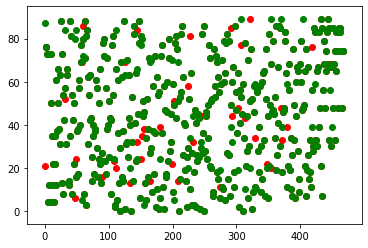

In [57]:
results.shape
plt.scatter(range(total_classification), final_results, c='r');
plt.scatter(range(total_classification), test_y, c='g');
plt.show()

Text(0.5, 0, 'epoch')

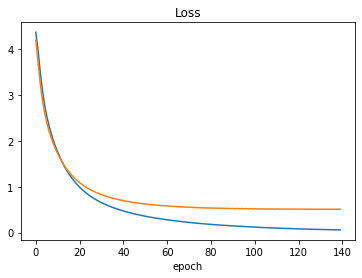

In [58]:
plt.plot(history.history['loss'],)
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

In [59]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(test_y, final_results)
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
#accuracy
Accuracy = (TP+TN)/(TP+TN+FP+FN)

print('False Positive Rate :', FPR)
print('False Negative Rate :',FNR)
#print('Accuracy :',Accuracy)

False Positive Rate : [0.         0.         0.         0.         0.         0.
 0.00215983 0.         0.         0.         0.         0.00215983
 0.         0.00215517 0.00431034 0.         0.00215517 0.
 0.         0.         0.00431034 0.00215983 0.00430108 0.00215517
 0.00431034 0.         0.         0.         0.         0.
 0.         0.         0.00431034 0.00431965 0.00215983 0.00215054
 0.         0.         0.00215517 0.00431965 0.         0.
 0.         0.00215517 0.00431965 0.         0.         0.
 0.00649351 0.         0.         0.00215517 0.00215517 0.
 0.         0.         0.00215983 0.         0.00215517 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.00431965 0.00431034 0.         0.
 0.         0.         0.         0.         0.00214133 0.00215517
 0.         0.         0.         0.00215517 0.         0.
 0.00215054 0.0021645  0.00215983 0.         0.         0.00215983]
False Negative Rate : [0.         0.         0.     

In [60]:
print('False Positive Rate :',np.mean(FPR))
print('False Negative Rate :',np.mean(FNR))
#print('Accuracy:',np.mean(Accuracy)*100)

False Positive Rate : 0.0010544704811330542
False Negative Rate : 0.10166666666666666


In [61]:
from sklearn.metrics import classification_report
print(print(classification_report(test_y,final_results, zero_division=0)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      0.80      0.89         5
           4       1.00      1.00      1.00         4
           5       1.00      0.60      0.75         5
           6       0.86      1.00      0.92         6
           7       1.00      1.00      1.00         6
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         6
          10       1.00      0.83      0.91         6
          11       0.86      1.00      0.92         6
          12       1.00      1.00      1.00         4
          13       0.83      1.00      0.91         5
          14       0.71      1.00      0.83         5
          15       1.00      1.00      1.00         6
          16       0.83      1.00      0.91         5
          17       1.00    